In [1]:
import torch

from tqdm import tqdm
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm
from tqdm import trange

from IPython.display import clear_output
from IPython.display import set_matplotlib_formats

In [2]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
"""
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = 'samples'
"""

class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
generator = GeneratorNet().to(device) 
discriminator = DiscriminatorNet().to(device)

# Loss and optimizer
criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

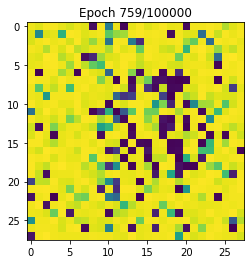

In [ ]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

num_epochs = int(1e5)
import time
for epoch in (range(num_epochs)):
    for i, (images, _) in enumerate((trainloader)):
        
        batch_size=images.shape[0]
        
        #######################################################
        
        # TRAINING OF THE DISCRIMINATOR
        
        # Reset gradients
        d_optimizer.zero_grad()
        
        # Acquire the real and the fake images
        images_real = images.reshape(batch_size, -1).to(device)
        images_fake = generator(noise(batch_size)).detach()
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train the discriminator on real images
        outputs = discriminator(images_real)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()
        
        # Train the discriminator of fake images
        outputs = discriminator(images_fake)
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()
        
        # Update discriminator weights
        d_optimizer.step()
        
        
        #################################################
        
        # TRAINING OF THE GENERATOR
        # Reset gradients
        g_optimizer.zero_grad()
        
        # Acquire fake images
        images_fake = generator(noise(batch_size))

        # Sample noise and generate fake data
        prediction=discriminator(images_fake)
        
        # Calculate error and backpropagate
        g_loss=criterion(prediction,real_labels)
        g_loss.backward()
        
        # Update weights with gradients
        g_optimizer.step()
        
        clear_output(True)
        images_generated=images_fake.detach().cpu().numpy().reshape((batch_size,28,28))
        images_generated=images_generated
        
        
        # Create two subplots and unpack the output array immediately
        #f, axs = plt.subplots(1, 4, sharey=True)
        plt.figure()
        plt.imshow(images_generated[0])
        plt.title('Epoch '+str(epoch)+'/'+str(num_epochs))
        plt.show()
        #time.sleep(1)
        #clear_output(True)       